In [4]:
import pandas as pd
import missingno as msno
import chart_studio.plotly as py
import cufflinks as cf
cf.go_offline(connected=True)

In [5]:
# 변수정리

# df -> 통합 데이터
# product_order_month_df -> 월별 카테고리 데이터
# product_order_month_max_count -> 월별 카테고리 best건수 카테고리
# product_order_month_max_price -> 월별 카테고리 best매출 카테고리
# month_payment_df -> 월별 매출 df
# payment_type -> 지불 방법 df
# locations -> 지역 df
# locations_payment_values  -> 지역별 매출 df

### 파일로드

In [7]:
customers = pd.read_csv("data/olist_customers_dataset.csv", encoding="utf-8")
categorys = pd.read_csv("data/product_category_name_translation.csv", encoding="utf-8")
products = pd.read_csv("data/olist_products_dataset.csv", encoding="utf-8")
orders = pd.read_csv("data/olist_orders_dataset.csv", encoding="utf-8")
order_items = pd.read_csv("data/olist_order_items_dataset.csv", encoding="utf-8")
payments = pd.read_csv("data/olist_order_payments_dataset.csv", encoding="utf-8")
reviews = pd.read_csv("data/olist_order_reviews_dataset.csv", encoding="utf-8")
sellers = pd.read_csv("data/olist_sellers_dataset.csv", encoding="utf-8")
geolocation = pd.read_csv("data/olist_geolocation_dataset.csv", encoding="utf-8")

### 데이터 통합

In [8]:
customers1=customers[["customer_id","customer_city","customer_state"]]
customers1.head(1)

,customer_id,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,franca,SP


In [9]:
products1 = products[["product_id","product_category_name"]]
products1 = products1.dropna()
products1.head(1)

,product_id,product_category_name
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria


In [10]:
orders1=orders[["order_id","customer_id","order_purchase_timestamp","order_delivered_carrier_date","order_delivered_customer_date","order_estimated_delivery_date"]]
orders1 = orders1.dropna()
orders1.head(1)

,order_id,customer_id,order_purchase_timestamp,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00


In [11]:
reviews1 = reviews[["order_id","review_score"]]
reviews1 = reviews1.drop_duplicates("order_id",keep="first")
reviews1.head(1)

,order_id,review_score
0,73fc7af87114b39712e6da79b0a377eb,4


In [12]:
order_items1 = order_items.drop_duplicates("order_id", keep="first")
order_items1= order_items1[["order_id","product_id"]]
order_items1.head(1)

,order_id,product_id
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61


In [13]:
payments1 = payments.groupby("order_id")["payment_value"].sum().reset_index()
payments1.head(1)

,order_id,payment_value
0,00010242fe8c5a6d1ba2dd792cb16214,72.19


In [14]:
#### merge

In [15]:
# product1 & category merge
products_name = pd.merge(products1, categorys, on="product_category_name")
products_name = products_name.drop(columns="product_category_name")
products_name.head(1)

,product_id,product_category_name_english
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumery


In [16]:
# produst_name & order_items1 merge
order_products_name = pd.merge(order_items1, products_name, on="product_id")
order_products_name.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97229 entries, 0 to 97228
Data columns (total 3 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       97229 non-null  object
 1   product_id                     97229 non-null  object
 2   product_category_name_english  97229 non-null  object
dtypes: object(3)
memory usage: 3.0+ MB


In [17]:
#customer1 & order1 merge
customer_order = pd.merge(customers1, orders1, on="customer_id")
customer_order.head(1)

,customer_id,customer_city,customer_state,order_id,order_purchase_timestamp,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,franca,SP,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:05:35,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00


In [18]:
# customer_order & review merge
customer_order_review = pd.merge(customer_order, reviews1, on="order_id")
customer_order_review.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96475 entries, 0 to 96474
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   customer_id                    96475 non-null  object
 1   customer_city                  96475 non-null  object
 2   customer_state                 96475 non-null  object
 3   order_id                       96475 non-null  object
 4   order_purchase_timestamp       96475 non-null  object
 5   order_delivered_carrier_date   96475 non-null  object
 6   order_delivered_customer_date  96475 non-null  object
 7   order_estimated_delivery_date  96475 non-null  object
 8   review_score                   96475 non-null  int64 
dtypes: int64(1), object(8)
memory usage: 7.4+ MB


In [19]:
# customer_order_review & payment1 merge
customer_order_review_payment = pd.merge(customer_order_review, payments1, on="order_id")
customer_order_review_payment.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96474 entries, 0 to 96473
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   customer_id                    96474 non-null  object 
 1   customer_city                  96474 non-null  object 
 2   customer_state                 96474 non-null  object 
 3   order_id                       96474 non-null  object 
 4   order_purchase_timestamp       96474 non-null  object 
 5   order_delivered_carrier_date   96474 non-null  object 
 6   order_delivered_customer_date  96474 non-null  object 
 7   order_estimated_delivery_date  96474 non-null  object 
 8   review_score                   96474 non-null  int64  
 9   payment_value                  96474 non-null  float64
dtypes: float64(1), int64(1), object(8)
memory usage: 8.1+ MB


In [20]:
# customer_order_review_payment & order_products_name merge
df = pd.merge(order_products_name, customer_order_review_payment, on="order_id")
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95096 entries, 0 to 95095
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_id                       95096 non-null  object 
 1   product_id                     95096 non-null  object 
 2   product_category_name_english  95096 non-null  object 
 3   customer_id                    95096 non-null  object 
 4   customer_city                  95096 non-null  object 
 5   customer_state                 95096 non-null  object 
 6   order_purchase_timestamp       95096 non-null  object 
 7   order_delivered_carrier_date   95096 non-null  object 
 8   order_delivered_customer_date  95096 non-null  object 
 9   order_estimated_delivery_date  95096 non-null  object 
 10  review_score                   95096 non-null  int64  
 11  payment_value                  95096 non-null  float64
dtypes: float64(1), int64(1), object(10)
memory usa

In [21]:
df.head()

,order_id,product_id,product_category_name_english,customer_id,customer_city,customer_state,order_purchase_timestamp,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_score,payment_value
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,cool_stuff,3ce436f183e68e07877b285a838db11a,campos dos goytacazes,RJ,2017-09-13 08:59:02,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29 00:00:00,5,72.19
1,130898c0987d1801452a8ed92a670612,4244733e06e7ecb4970a6e2683c13e61,cool_stuff,e6eecc5a77de221464d1c4eaff0a9b64,jatai,GO,2017-06-28 11:52:20,2017-07-05 12:00:33,2017-07-13 20:39:29,2017-07-26 00:00:00,5,73.86
2,532ed5e14e24ae1f0d735b91524b98b9,4244733e06e7ecb4970a6e2683c13e61,cool_stuff,4ef55bf80f711b372afebcb7c715344a,belo horizonte,MG,2018-05-18 10:25:53,2018-05-23 14:05:00,2018-06-04 18:34:26,2018-06-07 00:00:00,4,83.23
3,6f8c31653edb8c83e1a739408b5ff750,4244733e06e7ecb4970a6e2683c13e61,cool_stuff,30407a72ad8b3f4df4d15369126b20c9,sao jose dos pinhais,PR,2017-08-01 18:38:42,2017-08-02 19:07:36,2017-08-09 21:26:33,2017-08-25 00:00:00,5,75.07
4,7d19f4ef4d04461989632411b7e588b9,4244733e06e7ecb4970a6e2683c13e61,cool_stuff,91a792fef70ecd8cc69d3c7feb3d12da,conselheiro lafaiete,MG,2017-08-10 21:48:40,2017-08-11 19:43:07,2017-08-24 20:04:21,2017-09-01 00:00:00,5,72.19


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95096 entries, 0 to 95095
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_id                       95096 non-null  object 
 1   product_id                     95096 non-null  object 
 2   product_category_name_english  95096 non-null  object 
 3   customer_id                    95096 non-null  object 
 4   customer_city                  95096 non-null  object 
 5   customer_state                 95096 non-null  object 
 6   order_purchase_timestamp       95096 non-null  object 
 7   order_delivered_carrier_date   95096 non-null  object 
 8   order_delivered_customer_date  95096 non-null  object 
 9   order_estimated_delivery_date  95096 non-null  object 
 10  review_score                   95096 non-null  int64  
 11  payment_value                  95096 non-null  float64
dtypes: float64(1), int64(1), object(10)
memory usa

In [23]:
df["order_purchase_timestamp"] = pd.to_datetime(df["order_purchase_timestamp"], format="%Y-%m-%d %H:%M:%S", errors="raise")

In [24]:
payment2 = payments[["order_id","payment_type"]]

In [25]:
payment2= payment2.drop_duplicates("order_id", keep="first")

In [26]:
df = pd.merge(df, payment2, on="order_id")

In [27]:
# 최종데이터 df
df.head()

,order_id,product_id,product_category_name_english,customer_id,customer_city,customer_state,order_purchase_timestamp,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_score,payment_value,payment_type
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,cool_stuff,3ce436f183e68e07877b285a838db11a,campos dos goytacazes,RJ,2017-09-13 08:59:02,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29 00:00:00,5,72.19,credit_card
1,130898c0987d1801452a8ed92a670612,4244733e06e7ecb4970a6e2683c13e61,cool_stuff,e6eecc5a77de221464d1c4eaff0a9b64,jatai,GO,2017-06-28 11:52:20,2017-07-05 12:00:33,2017-07-13 20:39:29,2017-07-26 00:00:00,5,73.86,boleto
2,532ed5e14e24ae1f0d735b91524b98b9,4244733e06e7ecb4970a6e2683c13e61,cool_stuff,4ef55bf80f711b372afebcb7c715344a,belo horizonte,MG,2018-05-18 10:25:53,2018-05-23 14:05:00,2018-06-04 18:34:26,2018-06-07 00:00:00,4,83.23,credit_card
3,6f8c31653edb8c83e1a739408b5ff750,4244733e06e7ecb4970a6e2683c13e61,cool_stuff,30407a72ad8b3f4df4d15369126b20c9,sao jose dos pinhais,PR,2017-08-01 18:38:42,2017-08-02 19:07:36,2017-08-09 21:26:33,2017-08-25 00:00:00,5,75.07,credit_card
4,7d19f4ef4d04461989632411b7e588b9,4244733e06e7ecb4970a6e2683c13e61,cool_stuff,91a792fef70ecd8cc69d3c7feb3d12da,conselheiro lafaiete,MG,2017-08-10 21:48:40,2017-08-11 19:43:07,2017-08-24 20:04:21,2017-09-01 00:00:00,5,72.19,credit_card


<div class="alert alert-block" style="border: 1px solid #FFB300;background-color:#F9FBE7;">
<font size="4em" style="font-weight:bold;color:#3f8dbf;">월별 매출액</font><br>
</div>

In [28]:
# 필요한 컬럼 뽑아내기
month_payment_df = df[["order_purchase_timestamp","payment_value"]].copy()
month_payment_df.head(1)

,order_purchase_timestamp,payment_value
0,2017-09-13 08:59:02,72.19


In [29]:
month_payment_df = month_payment_df.groupby(pd.Grouper(key='order_purchase_timestamp', freq ="M")).sum()
month_payment_df.head()

,payment_value
order_purchase_timestamp,
2016-10-31,47175.28
2016-11-30,0.00
2016-12-31,19.62
2017-01-31,125746.94
2017-02-28,261752.64


In [30]:
month_payment_df.iplot(kind="bar")

In [31]:
# 시각화 세분화

<div class="alert alert-block" style="border: 1px solid #FFB300;background-color:#F9FBE7;">
<font size="4em" style="font-weight:bold;color:#3f8dbf;">지불 방법</font><br>
</div>

In [32]:
df.head()

,order_id,product_id,product_category_name_english,customer_id,customer_city,customer_state,order_purchase_timestamp,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_score,payment_value,payment_type
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,cool_stuff,3ce436f183e68e07877b285a838db11a,campos dos goytacazes,RJ,2017-09-13 08:59:02,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29 00:00:00,5,72.19,credit_card
1,130898c0987d1801452a8ed92a670612,4244733e06e7ecb4970a6e2683c13e61,cool_stuff,e6eecc5a77de221464d1c4eaff0a9b64,jatai,GO,2017-06-28 11:52:20,2017-07-05 12:00:33,2017-07-13 20:39:29,2017-07-26 00:00:00,5,73.86,boleto
2,532ed5e14e24ae1f0d735b91524b98b9,4244733e06e7ecb4970a6e2683c13e61,cool_stuff,4ef55bf80f711b372afebcb7c715344a,belo horizonte,MG,2018-05-18 10:25:53,2018-05-23 14:05:00,2018-06-04 18:34:26,2018-06-07 00:00:00,4,83.23,credit_card
3,6f8c31653edb8c83e1a739408b5ff750,4244733e06e7ecb4970a6e2683c13e61,cool_stuff,30407a72ad8b3f4df4d15369126b20c9,sao jose dos pinhais,PR,2017-08-01 18:38:42,2017-08-02 19:07:36,2017-08-09 21:26:33,2017-08-25 00:00:00,5,75.07,credit_card
4,7d19f4ef4d04461989632411b7e588b9,4244733e06e7ecb4970a6e2683c13e61,cool_stuff,91a792fef70ecd8cc69d3c7feb3d12da,conselheiro lafaiete,MG,2017-08-10 21:48:40,2017-08-11 19:43:07,2017-08-24 20:04:21,2017-09-01 00:00:00,5,72.19,credit_card


In [33]:
payment_type = df[["payment_type","order_id"]].copy()
payment_type.head()

,payment_type,order_id
0,credit_card,00010242fe8c5a6d1ba2dd792cb16214
1,boleto,130898c0987d1801452a8ed92a670612
2,credit_card,532ed5e14e24ae1f0d735b91524b98b9
3,credit_card,6f8c31653edb8c83e1a739408b5ff750
4,credit_card,7d19f4ef4d04461989632411b7e588b9


In [34]:
payment_type["payment_type"].unique()

array(['credit_card', 'boleto', 'voucher', 'debit_card'], dtype=object)

In [35]:
payment_type = payment_type.groupby("payment_type")["order_id"].size().sort_values(ascending=False)
payment_type

payment_type
credit_card    72177
boleto         18925
voucher         2540
debit_card      1454
Name: order_id, dtype: int64

In [36]:
payment_type.iplot(kind="bar")

In [37]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(
    go.Pie(
        labels = payment_type.index, values = payment_type.values
    )
)

In [38]:
# 시각화 세분화

<div class="alert alert-block" style="border: 1px solid #FFB300;background-color:#F9FBE7;">
<font size="4em" style="font-weight:bold;color:#3f8dbf;">지역별 매출액</font><br>
</div>

In [39]:
df.head()

,order_id,product_id,product_category_name_english,customer_id,customer_city,customer_state,order_purchase_timestamp,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_score,payment_value,payment_type
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,cool_stuff,3ce436f183e68e07877b285a838db11a,campos dos goytacazes,RJ,2017-09-13 08:59:02,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29 00:00:00,5,72.19,credit_card
1,130898c0987d1801452a8ed92a670612,4244733e06e7ecb4970a6e2683c13e61,cool_stuff,e6eecc5a77de221464d1c4eaff0a9b64,jatai,GO,2017-06-28 11:52:20,2017-07-05 12:00:33,2017-07-13 20:39:29,2017-07-26 00:00:00,5,73.86,boleto
2,532ed5e14e24ae1f0d735b91524b98b9,4244733e06e7ecb4970a6e2683c13e61,cool_stuff,4ef55bf80f711b372afebcb7c715344a,belo horizonte,MG,2018-05-18 10:25:53,2018-05-23 14:05:00,2018-06-04 18:34:26,2018-06-07 00:00:00,4,83.23,credit_card
3,6f8c31653edb8c83e1a739408b5ff750,4244733e06e7ecb4970a6e2683c13e61,cool_stuff,30407a72ad8b3f4df4d15369126b20c9,sao jose dos pinhais,PR,2017-08-01 18:38:42,2017-08-02 19:07:36,2017-08-09 21:26:33,2017-08-25 00:00:00,5,75.07,credit_card
4,7d19f4ef4d04461989632411b7e588b9,4244733e06e7ecb4970a6e2683c13e61,cool_stuff,91a792fef70ecd8cc69d3c7feb3d12da,conselheiro lafaiete,MG,2017-08-10 21:48:40,2017-08-11 19:43:07,2017-08-24 20:04:21,2017-09-01 00:00:00,5,72.19,credit_card


In [40]:
locations = df[["order_id","product_category_name_english","customer_city","payment_value"]].copy()
locations.head()

,order_id,product_category_name_english,customer_city,payment_value
0,00010242fe8c5a6d1ba2dd792cb16214,cool_stuff,campos dos goytacazes,72.19
1,130898c0987d1801452a8ed92a670612,cool_stuff,jatai,73.86
2,532ed5e14e24ae1f0d735b91524b98b9,cool_stuff,belo horizonte,83.23
3,6f8c31653edb8c83e1a739408b5ff750,cool_stuff,sao jose dos pinhais,75.07
4,7d19f4ef4d04461989632411b7e588b9,cool_stuff,conselheiro lafaiete,72.19


In [41]:
locations_payment_values = locations.groupby("customer_city")["payment_value"].sum().sort_values(ascending=False)
locations_payment_values.head()

customer_city
sao paulo         2077592.46
rio de janeiro    1099331.55
belo horizonte     399717.84
brasilia           342178.67
curitiba           236457.84
Name: payment_value, dtype: float64

In [42]:
# top 10
locations_payment_values_top10 = locations_payment_values.head(10)

In [43]:
# 시각화
locations_payment_values_top10.iplot(kind="bar")

In [44]:
# 시각화 세분화

<div class="alert alert-block" style="border: 1px solid #FFB300;background-color:#F9FBE7;">
<font size="4em" style="font-weight:bold;color:#3f8dbf;">olist 월별 제품 카테고리 트렌드 분석</font><br>
</div>

In [45]:
# 필요한 컬럼 가져오기
product_order_month_df = df[["product_category_name_english","payment_value","order_purchase_timestamp"]].copy()
product_order_month_df["order_purchase_timestamp"] = product_order_month_df["order_purchase_timestamp"].astype("str")
product_order_month_df["months"] = product_order_month_df["order_purchase_timestamp"].str.split("-",expand=True)[1].astype("int")
product_order_month_df.drop(columns="order_purchase_timestamp", inplace=True)
product_order_month_df.head()

,product_category_name_english,payment_value,months
0,cool_stuff,72.19,9
1,cool_stuff,73.86,6
2,cool_stuff,83.23,5
3,cool_stuff,75.07,8
4,cool_stuff,72.19,8


In [46]:
# 컬럼이름 변경하기
product_order_month_df = product_order_month_df.rename(columns={"product_category_name_english":"category"})
product_order_month_df.head(2)

,category,payment_value,months
0,cool_stuff,72.19,9
1,cool_stuff,73.86,6


In [47]:
# (1) 월별 카테고리 건수 데이터 구하기

In [48]:
product_order_month_count = product_order_month_df.groupby(["months", "category"])["payment_value"].size().reset_index()
product_order_month_count

,months,category,payment_value
0,1,agro_industry_and_commerce,17
1,1,air_conditioning,25
2,1,art,18
3,1,audio,25
4,1,auto,270
...,...,...,...
790,12,stationery,228
791,12,tablets_printing_image,6
792,12,telephony,236
793,12,toys,412


In [49]:
# 월별 max 값 & category 가져오기
product_order_month_max_count = []

for num in range(1,13):
    data = product_order_month_count[product_order_month_count["months"]==num]
    data = data[data["payment_value"]==data["payment_value"].max()]
    product_order_month_max_count.append(data)

product_order_month_max_count = pd.concat(product_order_month_max_count).reset_index(drop=True)
product_order_month_max_count

,months,category,payment_value
0,1,bed_bath_table,725
1,2,computers_accessories,881
2,3,bed_bath_table,884
3,4,bed_bath_table,823
4,5,health_beauty,927
5,6,health_beauty,1016
6,7,bed_bath_table,1000
7,8,health_beauty,1098
8,9,bed_bath_table,450
9,10,bed_bath_table,440


In [50]:
# 컬럼명 바꾸기
product_order_month_max_count.rename(columns={"payment_value":"count"}, inplace=True)
product_order_month_max_count.head(2)

,months,category,count
0,1,bed_bath_table,725
1,2,computers_accessories,881


In [51]:
# month 이름 바꿔주기
def months(x):
    if x == 1:
        x = "Jan"
    elif x == 2:
        x = "Feb"
    elif x == 3:
        x = "Mar"
    elif x == 4:
        x = "Apr"
    elif x == 5:
        x = "May"
    elif x == 6:
        x = "Jun"
    elif x == 7:
        x = "Jul"
    elif x == 8:
        x = "Aug"
    elif x == 9:
        x = "Sep"
    elif x == 10:
        x = "Oct"
    elif x == 11:
        x = "Nov"
    elif x == 12:
        x = "Dec"
    return x

In [52]:
product_order_month_max_count["months"] = product_order_month_max_count["months"].apply(months)
product_order_month_max_count["category_of_month"] = product_order_month_max_count["category"] + "(" + product_order_month_max_count["months"] + ")"
product_order_month_max_count = product_order_month_max_count[["category_of_month","count"]]
product_order_month_max_count

,category_of_month,count
0,bed_bath_table(Jan),725
1,computers_accessories(Feb),881
2,bed_bath_table(Mar),884
3,bed_bath_table(Apr),823
4,health_beauty(May),927
5,health_beauty(Jun),1016
6,bed_bath_table(Jul),1000
7,health_beauty(Aug),1098
8,bed_bath_table(Sep),450
9,bed_bath_table(Oct),440


In [53]:
#(2) 월별 카테고리 금액

In [54]:
product_order_month_price = product_order_month_df.groupby(["months", "category"])["payment_value"].sum().reset_index()
product_order_month_price

,months,category,payment_value
0,1,agro_industry_and_commerce,6404.27
1,1,air_conditioning,5942.85
2,1,art,2698.30
3,1,audio,4233.39
4,1,auto,46519.06
...,...,...,...
790,12,stationery,29413.90
791,12,tablets_printing_image,485.33
792,12,telephony,16388.48
793,12,toys,63352.46


In [55]:
product_order_month_max_price = []

for num in range(1,13):
    data = product_order_month_price[product_order_month_price["months"]==num]
    data = data[data["payment_value"]==data["payment_value"].max()]
    product_order_month_max_price.append(data)

product_order_month_max_price = pd.concat(product_order_month_max_price).reset_index(drop=True)
product_order_month_max_price

,months,category,payment_value
0,1,sports_leisure,111079.73
1,2,computers_accessories,130065.78
2,3,computers_accessories,130890.78
3,4,health_beauty,129167.03
4,5,watches_gifts,166843.66
5,6,health_beauty,160806.31
6,7,health_beauty,158666.05
7,8,health_beauty,190715.03
8,9,bed_bath_table,62014.85
9,10,watches_gifts,72608.08


In [56]:
product_order_month_max_price["months"] = product_order_month_max_price["months"].apply(months)
product_order_month_max_price["category_of_month"] = product_order_month_max_price["category"] + "(" + product_order_month_max_price["months"] + ")"
product_order_month_max_price = product_order_month_max_price[["category_of_month","payment_value"]]
product_order_month_max_price.head(2)

,category_of_month,payment_value
0,sports_leisure(Jan),111079.73
1,computers_accessories(Feb),130065.78


### 3. 데이터 시각화

In [57]:
product_order_month_max_count

,category_of_month,count
0,bed_bath_table(Jan),725
1,computers_accessories(Feb),881
2,bed_bath_table(Mar),884
3,bed_bath_table(Apr),823
4,health_beauty(May),927
5,health_beauty(Jun),1016
6,bed_bath_table(Jul),1000
7,health_beauty(Aug),1098
8,bed_bath_table(Sep),450
9,bed_bath_table(Oct),440


In [58]:
colors = ['#03588C',] * len(product_order_month_max_price["category_of_month"])
colors[7] = '#F24472'

In [59]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(
    go.Bar(
        x=product_order_month_max_count["category_of_month"], 
        y=product_order_month_max_count['count'],
        text=product_order_month_max_count['count'], 
        textposition='auto', 
        marker_color=colors
    )
)
fig.update_layout(
    {
        "title": {
            "text": "<b>category of the month</b>",
            "x": 0.5,
            "y": 0.9,
            "font": {
                "size": 12
            }
        },
        "xaxis": {
            "title": "Jan ~ Dec",
            "showticklabels":True,
            "dtick": 1,
            "tickfont": {
                "size": 15                
            }
        },
        "yaxis": {
            "title": "The number of Order Count"
        },
        "template":'plotly_white'
    }
)
fig.add_annotation(
            x="health_beauty(Aug)",
            y=1098,
            text="<b>Peaked Monthly</b>",
            showarrow=True,
            font=dict(
                size=10,
                color="#ffffff"
                ),
            align="center",
            arrowhead=2,
            arrowsize=1,
            arrowwidth=2,
            arrowcolor="#77CFD9",
            ax=20,
            ay=-30,
            bordercolor="#77CFD9",
            borderwidth=2,
            borderpad=4,
            bgcolor="#F25D50",
            opacity=0.9
)
fig.show()

In [60]:
# 2) 금액별 그래프

In [61]:
product_order_month_max_price

,category_of_month,payment_value
0,sports_leisure(Jan),111079.73
1,computers_accessories(Feb),130065.78
2,computers_accessories(Mar),130890.78
3,health_beauty(Apr),129167.03
4,watches_gifts(May),166843.66
5,health_beauty(Jun),160806.31
6,health_beauty(Jul),158666.05
7,health_beauty(Aug),190715.03
8,bed_bath_table(Sep),62014.85
9,watches_gifts(Oct),72608.08


In [62]:
colors = ['#03588C',] * len(product_order_month_max_price["category_of_month"])
colors[7] = '#F24472'

In [63]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(
    go.Bar(
        x=product_order_month_max_price["category_of_month"], 
        y=product_order_month_max_price['payment_value'],
        text=product_order_month_max_price['payment_value'], 
        textposition='auto', 
        texttemplate='RS$ %{text:,.0f}',
        marker_color=colors
    )
)
fig.update_layout(
    {
        "title": {
            "text": "<b>category of the month</b>",
            "x": 0.5,
            "y": 0.9,
            "font": {
                "size": 12
            }
        },
        "xaxis": {
            "title": "Jan~Dec",
            "showticklabels":True,
            "dtick": 1,
            "tickfont": {
                "size": 15                
            }
        },
        "yaxis": {
            "title": "The number of Order Price"
        },
        "template":'plotly_white'
    }
)
fig.add_annotation(
            x="health_beauty(Aug)",
            y=190715.03,
            text="<b>Peaked Monthly</b>",
            showarrow=True,
            font=dict(
                size=10,
                color="#ffffff"
                ),
            align="center",
            arrowhead=2,
            arrowsize=1,
            arrowwidth=2,
            arrowcolor="#77CFD9",
            ax=20,
            ay=-30,
            bordercolor="#77CFD9",
            borderwidth=2,
            borderpad=4,
            bgcolor="#F25D50",
            opacity=0.9
)
fig.show()

<div class="alert alert-block" style="border: 1px solid #FFB300;background-color:#F9FBE7;">
<font size="4em" style="font-weight:bold;color:#3f8dbf;">olist 요일로 구분된 시간대별 구매수 분석</font><br>
</div>

In [64]:
#root_df = df에서 order_purchase_timestamp만 추출해온 것
#make_time_df = datetime64로 형변환 후 day_of_the_week(요일),hour(시간)컬럼 추가
#time_df = 요일별로 나누어 시간별로 전처리한 make_time_df를 concat해 하나로 정리한 데이터
# purchase_by_day = pivot table된 time_df(count가 데이터로 들어감

### 1. 데이터 추출

In [65]:
root_df = df["order_purchase_timestamp"]
root_df

0       2017-09-13 08:59:02
1       2017-06-28 11:52:20
2       2018-05-18 10:25:53
3       2017-08-01 18:38:42
4       2017-08-10 21:48:40
                ...        
95091   2018-07-13 20:04:05
95092   2018-08-18 10:00:59
95093   2017-06-01 16:53:03
95094   2017-12-18 16:33:07
95095   2018-06-09 17:00:18
Name: order_purchase_timestamp, Length: 95096, dtype: datetime64[ns]

### 2. 형변환

In [66]:
make_time_df = pd.to_datetime(root_df,format='%Y-%m-%d %H:%M:%S',errors='raise')
make_time_df

0       2017-09-13 08:59:02
1       2017-06-28 11:52:20
2       2018-05-18 10:25:53
3       2017-08-01 18:38:42
4       2017-08-10 21:48:40
                ...        
95091   2018-07-13 20:04:05
95092   2018-08-18 10:00:59
95093   2017-06-01 16:53:03
95094   2017-12-18 16:33:07
95095   2018-06-09 17:00:18
Name: order_purchase_timestamp, Length: 95096, dtype: datetime64[ns]

In [67]:
make_time_df = pd.DataFrame(make_time_df)
make_time_df.head(1)

,order_purchase_timestamp
0,2017-09-13 08:59:02


In [68]:
make_time_df['day_of_the_week'] = make_time_df['order_purchase_timestamp'].dt.strftime("%A")
make_time_df.head(1)

,order_purchase_timestamp,day_of_the_week
0,2017-09-13 08:59:02,Wednesday


In [69]:
make_time_df['hour'] = make_time_df['order_purchase_timestamp'].dt.hour
make_time_df.head(1)

,order_purchase_timestamp,day_of_the_week,hour
0,2017-09-13 08:59:02,Wednesday,8


In [70]:
m = make_time_df[make_time_df['day_of_the_week']=='Monday']
m.head(1)

,order_purchase_timestamp,day_of_the_week,hour
7,2017-06-05 12:22:19,Monday,12


In [71]:
m_d = m.groupby('hour').size().reset_index(name="count")
m_d['day'] = 'Monday'
m_d.head(1)

,hour,count,day
0,0,311,Monday


In [72]:
t = make_time_df[make_time_df['day_of_the_week']=='Tuesday']
t.head(1)

,order_purchase_timestamp,day_of_the_week,hour
3,2017-08-01 18:38:42,Tuesday,18


In [73]:
t_d = t.groupby('hour').size().reset_index(name="count")
t_d['day'] = 'Tuesday'
t_d.head(1)

,hour,count,day
0,0,294,Tuesday


In [74]:
w = make_time_df[make_time_df['day_of_the_week']=='Wednesday']
w.head(1)

,order_purchase_timestamp,day_of_the_week,hour
0,2017-09-13 08:59:02,Wednesday,8


In [75]:
w_d = w.groupby('hour').size().reset_index(name="count")
w_d['day'] = 'Wednesday'
w_d.head(1)

,hour,count,day
0,0,380,Wednesday


In [76]:
th = make_time_df[make_time_df['day_of_the_week']=='Thursday']
th.head(1)

,order_purchase_timestamp,day_of_the_week,hour
4,2017-08-10 21:48:40,Thursday,21


In [77]:
th_d = th.groupby('hour').size().reset_index(name="count")
th_d['day'] = 'Thursday'
th_d.head(1)

,hour,count,day
0,0,341,Thursday


In [78]:
f = make_time_df[make_time_df['day_of_the_week']=='Friday']
f_d = f.groupby('hour').size().reset_index(name="count")
f_d['day'] = 'Friday'
f_d.head(1)

,hour,count,day
0,0,407,Friday


In [79]:
sa = make_time_df[make_time_df['day_of_the_week']=='Saturday']
sa.head(1)

,order_purchase_timestamp,day_of_the_week,hour
10,2018-01-06 14:03:53,Saturday,14


In [80]:
sa_d = sa.groupby('hour').size().reset_index(name="count")
sa_d['day'] = 'Saturday'
sa_d.head(1)

,hour,count,day
0,0,305,Saturday


In [81]:
su = make_time_df[make_time_df['day_of_the_week']=='Sunday']
su.head(1)

,order_purchase_timestamp,day_of_the_week,hour
6,2018-03-18 21:00:44,Sunday,21


In [82]:
su_d = su.groupby('hour').size().reset_index(name="count")
su_d['day'] = 'Sunday'
su_d.head(1)

,hour,count,day
0,0,252,Sunday


In [83]:
time_df = pd.concat([m_d,t_d,w_d,th_d,f_d,sa_d,su_d], axis=0)
time_df.head(1)

,hour,count,day
0,0,311,Monday


In [84]:
time_df["count"].sum()

95096

### 3. 시각화

In [85]:
purchase_by_day = time_df.pivot("day","hour", "count")
purchase_by_day = purchase_by_day.reindex(index=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])
purchase_by_day

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
day,,,,,,,,,,,,,,,,,,,,,
Monday,311,131,62,34,21,21,63,152,467,743,...,1054,1037,1044,940,882,908,983,1066,947,690
Tuesday,294,145,78,27,27,23,67,213,508,832,...,1074,987,1049,927,840,880,935,977,925,668
Wednesday,380,169,80,31,33,24,89,206,487,784,...,1011,940,991,926,802,811,876,912,841,588
Thursday,341,164,71,36,30,28,81,208,486,723,...,935,889,1029,873,742,786,809,823,823,525
Friday,407,208,65,46,39,34,90,198,484,742,...,918,935,925,780,690,744,707,693,666,493
Saturday,305,164,64,41,25,23,51,102,241,410,...,640,692,659,665,684,725,700,636,525,420
Sunday,252,136,67,41,26,23,28,102,200,341,...,650,689,677,762,863,872,933,839,843,586


In [86]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 8]

%matplotlib inline

from matplotlib import font_manager, rc
plt.rcParams["axes.unicode_minus"]=False

f_path = "/Library/Fonts/Arial Unicode.ttf"
font_name=font_manager.FontProperties(fname=f_path).get_name()
rc("font",family=font_name)

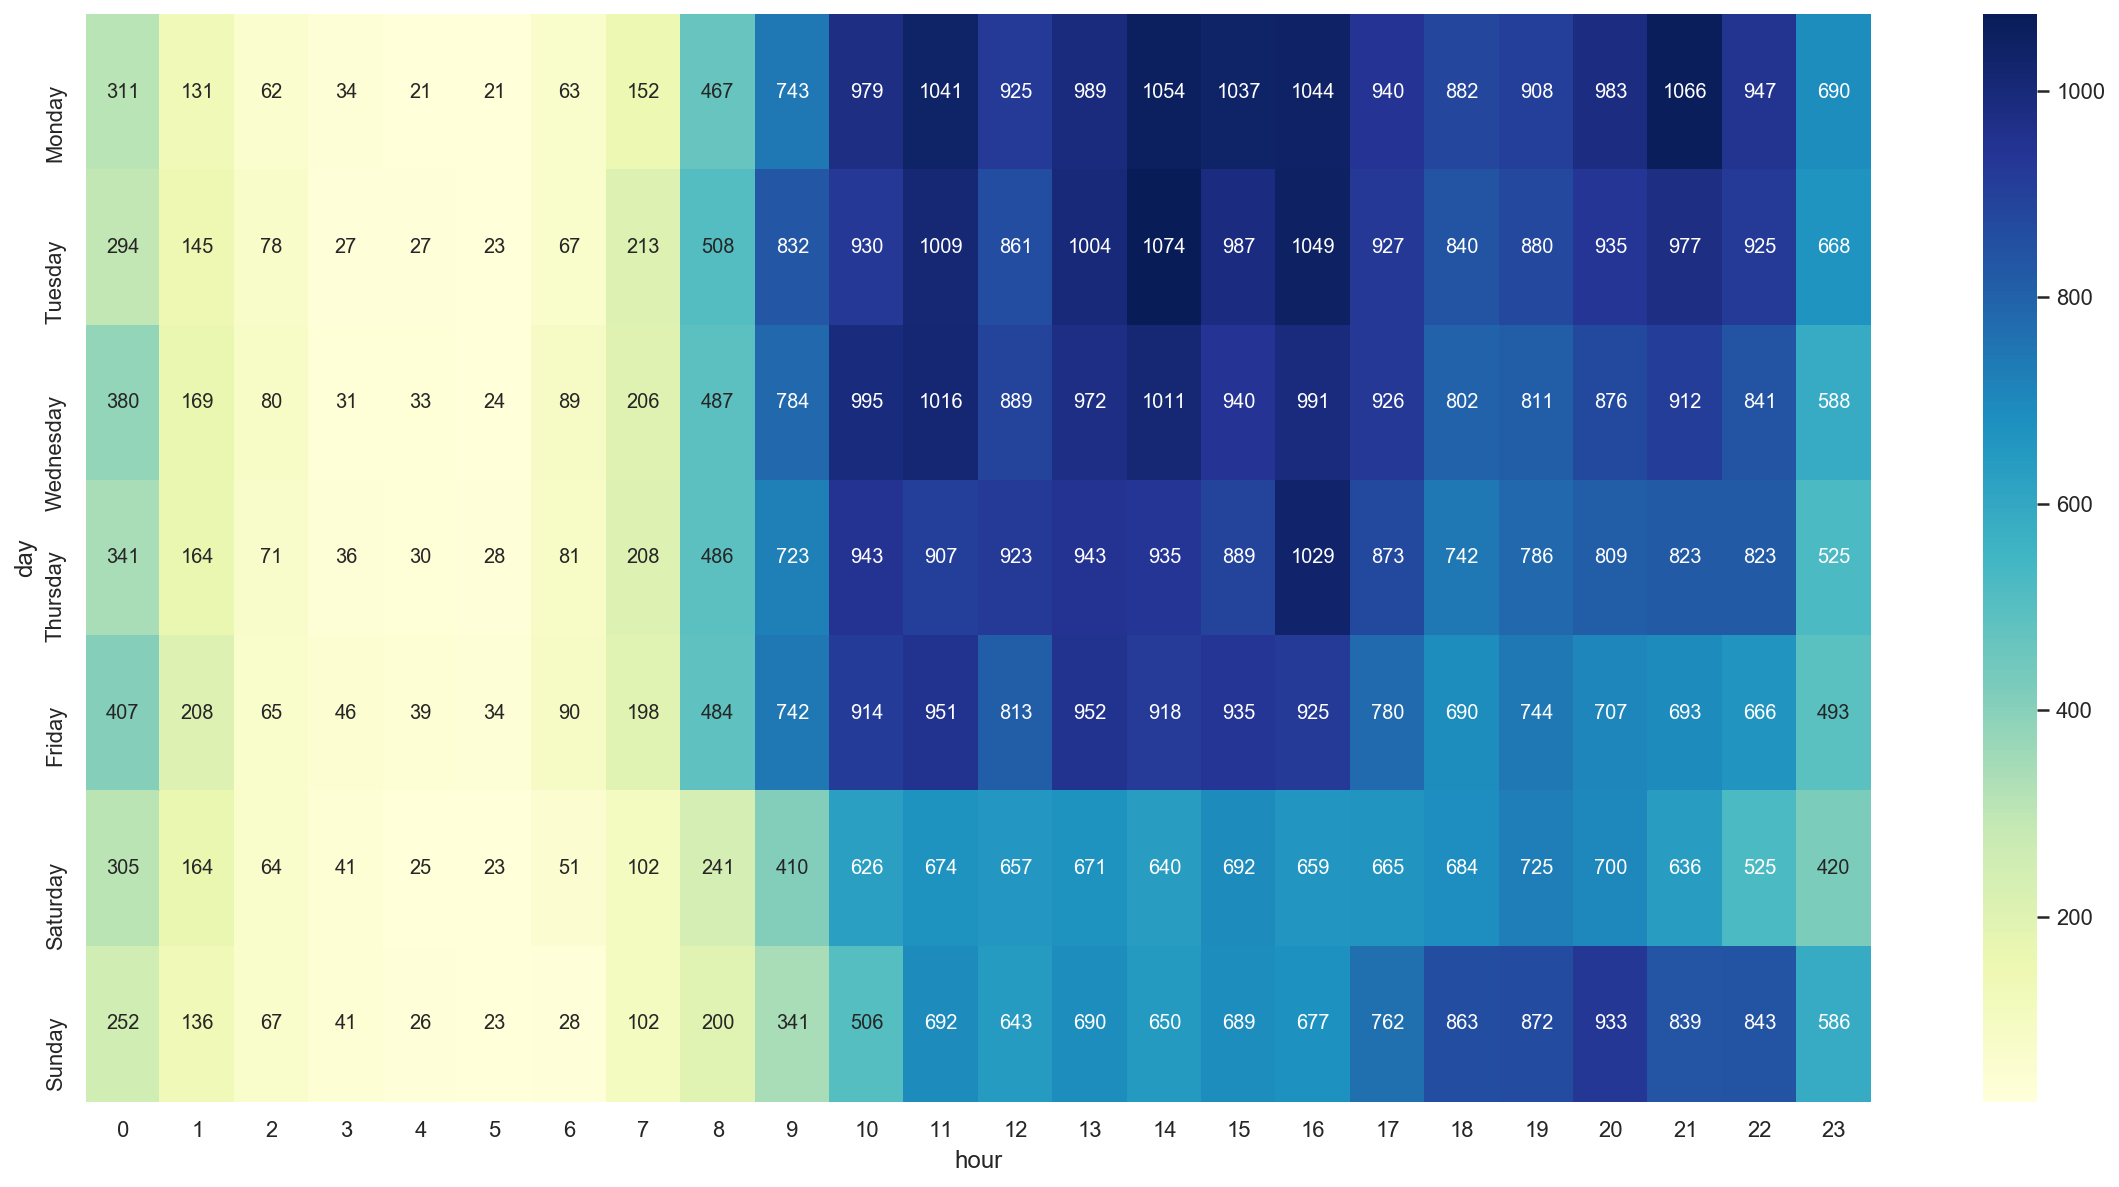

In [87]:
plt.figure(figsize=(20,10))
sns.heatmap(purchase_by_day,annot=True,fmt="d",cmap="YlGnBu")

plt.show()

<div class="alert alert-block" style="border: 1px solid #FFB300;background-color:#F9FBE7;">
<font size="4em" style="font-weight:bold;color:#3f8dbf;">olist 리뷰점수와 배송시간 간의 상관관계 분석</font><br>
</div>

In [88]:
#review_g_df, review_b_df : 각각 good , bad 리뷰로 나눈 데이터
# delivery_good, delivery_bad : 각각 good , bad 리뷰로 나눈 데이터의 배송기간과 딜레이 된 시간을 구한 데이터 

### 1. 데이터 전처리

In [89]:
# good_review와 bad_review 추려내기

In [90]:
# (1) good_review(score 4이상)

review_g_df = df[["order_purchase_timestamp","order_delivered_customer_date","order_estimated_delivery_date","review_score"]]
review_g_df = review_g_df[(review_g_df["review_score"]>3)]
review_g_df.head(2)

,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,review_score
0,2017-09-13 08:59:02,2017-09-20 23:43:48,2017-09-29 00:00:00,5
1,2017-06-28 11:52:20,2017-07-13 20:39:29,2017-07-26 00:00:00,5


In [91]:
# 형변환
order_purchase_timestamp_ = pd.to_datetime(review_g_df["order_purchase_timestamp"],format='%Y-%m-%d %H:%M:%S',errors='raise')
order_delivered_customer_date_ = pd.to_datetime(review_g_df["order_delivered_customer_date"],format='%Y-%m-%d %H:%M:%S',errors='raise')
order_estimated_delivery_date_ = pd.to_datetime(review_g_df["order_estimated_delivery_date"],format='%Y-%m-%d %H:%M:%S',errors='raise')

In [92]:
#배송기간과 딜레이 된 시간 데이터 프레임
day_of_delivery= (order_delivered_customer_date_-order_purchase_timestamp_).dt.days
differences_of_delivery_day =(order_estimated_delivery_date_-order_delivered_customer_date_).dt.days

delivery_good = pd.concat([day_of_delivery,differences_of_delivery_day],axis=1).rename(columns={0 : "period", 1:"delay"}) #-값일경우 delay

delivery_good.head(2)

,period,delay
0,7,8
1,15,12


In [93]:
#평균 배송기간
mean_delivery = delivery_good.agg({"period":"mean"})
mean_delivery

period    10.624207
dtype: float64

In [94]:
#평균 지연기간
mean_delay = delivery_good[delivery_good["delay"]<1]
mean_delay = mean_delay.agg({"delay":"mean"})
mean_delay

delay   -4.093858
dtype: float64

In [95]:
# (2) bad_review(score 3이하)

review_b_df = df[["order_purchase_timestamp","order_delivered_customer_date","order_estimated_delivery_date","review_score"]]
review_b_df = review_b_df[(review_b_df["review_score"]<4)]
review_b_df.head(2)

,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,review_score
7,2017-06-05 12:22:19,2017-06-26 13:52:03,2017-07-06 00:00:00,1
14,2018-02-17 22:29:16,2018-04-02 22:32:10,2018-03-23 00:00:00,1


In [96]:
#형변환
order_purchase_timestamp = pd.to_datetime(review_b_df["order_purchase_timestamp"],format='%Y-%m-%d %H:%M:%S',errors='raise')
order_delivered_customer_date = pd.to_datetime(review_b_df["order_delivered_customer_date"],format='%Y-%m-%d %H:%M:%S',errors='raise')
order_estimated_delivery_date = pd.to_datetime(review_b_df["order_estimated_delivery_date"],format='%Y-%m-%d %H:%M:%S',errors='raise')

In [97]:
#배송걸린 기간과 예정시간보다 더 소요된 시간 
days_of_delivery = (order_delivered_customer_date - order_purchase_timestamp).dt.days
difference_of_delivery_day =(order_estimated_delivery_date-order_delivered_customer_date).dt.days
delivery_bad = pd.concat([days_of_delivery,difference_of_delivery_day],axis=1).rename(columns={0 : "period", 1:"delay"}) #-값일경우 delay
delivery_bad.head(2)

,period,delay
7,21,9
14,44,-11


### 2. 평균값 구하기

In [98]:
# good_review

In [99]:
#평균 배송기간
mean_delivery = delivery_good.agg({"period":"mean"})
mean_delivery

period    10.624207
dtype: float64

In [100]:
#평균 지연기간
mean_delay = delivery_good[delivery_good["delay"]<1]
mean_delay = mean_delay.agg({"delay":"mean"})
mean_delay

delay   -4.093858
dtype: float64

In [101]:
# bad_review

In [102]:
#평균 배송기간
mean_delivery_bad= delivery_bad.agg({"period":"mean"})
mean_delivery_bad

period    17.474271
dtype: float64

In [103]:
#평균 지연기간
mean_delay_bad = delivery_bad[delivery_bad["delay"]<1]
mean_delay_bad = mean_delay_bad.agg({"delay":"mean"})
mean_delay_bad

delay   -11.267051
dtype: float64

### 3. 시각화

In [104]:
import plotly.graph_objects as go

time_of_ = ['average delivery period','average delay period']

fig = go.Figure()
fig.add_trace(go.Bar(x=time_of_, y=[10.6,4.9],
                base=0,
                marker_color='crimson',
                width=0.3,
                name='positive'))
fig.add_trace(go.Bar(x=time_of_, y=[17.4,11.2],
                base=0,
                marker_color='lightblue',
                width=0.3,
                name='negative'
                ))

fig.update_layout(
    title_text="Average of delivery and delay period")


fig.show()

<div class="alert alert-block" style="border: 1px solid #FFB300;background-color:#F9FBE7;">
<font size="4em" style="font-weight:bold;color:#3f8dbf;">olist 리뷰점수와 배송 딜레이와의 상관관계 분석</font><br>
</div>

In [105]:
# delay_good,delay_bad : 각 리뷰의 도착 예정시간에서 실제 도착한 날짜의 차이를 계산하여 "early","arrived_in_time","delayed"로 나눈 값

### 1. 데이터 전처리

In [106]:
# good review 의 도착 예정시간에서 실제 도착한 날짜의 차이를 계산하여 "early","arrived_in_time","delayed"로 나눈 값
delay_good = pd.DataFrame(delivery_good,columns=["delay"])

delay_good.loc[delivery_good.delay>0]='early'
delay_good.loc[delivery_good.delay==0]='arrived_in_time'
delay_good.loc[delivery_good.delay<0]='delayed'

delay_good.head()

,delay
0,early
1,early
2,early
3,early
4,early


In [107]:
# bad review 의 도착 예정시간에서 실제 도착한 날짜의 차이를 계산하여 "early","arrived_in_time","delayed"로 나눈 값

delay_bad = pd.DataFrame(delivery_bad,columns=["delay"])

delay_bad.loc[delivery_bad.delay>0]='early' 
delay_bad.loc[delivery_bad.delay==0]='arrived_in_time'
delay_bad.loc[delivery_bad.delay<0]='delayed'

delay_bad.head()

,delay
7,early
14,delayed
17,early
18,early
26,delayed


### 2. 시각화

In [108]:
import plotly.graph_objs as go

labels = ['early','arrived in time','delayed']
good_review_score = [70969,1135,2626]
bad_review_score = [14985,305,5076]

data1 = {
   "values": good_review_score,
   "labels": labels,
   "domain": {"column": 0},
   "hoverinfo":"label+percent",
    "hole": .4,
   "type": "pie"
}
data2 = {
   "values": bad_review_score,
   "labels": labels,
   "domain": {"column": 1},
   "hoverinfo":"label+percent",
    "hole": .4,
   "type": "pie"
}
data = [data1,data2]
layout = go.Layout(
   {
      "title":"Delay percentage",
      "grid": {"rows": 1, "columns": 2},
      "annotations": [
         {
            "font": {
               "size": 20
            },
            "showarrow": False,
            "text": "Positive",
            "x": 0.20,
            "y": 0.5
         },
         {
            "font": {
               "size": 20
            },
            "showarrow": False,
            "text": "Negative",
            "x": 0.8,
            "y": 0.5
         }
      ]
   }
)
figo = go.Figure(data = data, layout = layout)
figo.show()

<div class="alert alert-block" style="border: 1px solid #FFB300;background-color:#F9FBE7;">
<font size="4em" style="font-weight:bold;color:#3f8dbf;">olist 평점에 따른 배송기간과 구매수의 상관관계</font><br>
</div>

In [109]:
#total_df = df의 구매관련 시간대 컬럼과 리뷰스코어를 불러온 값

### 1. 데이터 전처리

In [110]:
total_df = df[["order_purchase_timestamp","order_delivered_customer_date","order_estimated_delivery_date","review_score"]]
total_df.head(2)

,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,review_score
0,2017-09-13 08:59:02,2017-09-20 23:43:48,2017-09-29 00:00:00,5
1,2017-06-28 11:52:20,2017-07-13 20:39:29,2017-07-26 00:00:00,5


### 2. 형변환

In [111]:
total_df["order_delivered_customer_date"] = pd.to_datetime(total_df["order_delivered_customer_date"],format='%Y-%m-%d',errors='raise')
total_df["order_estimated_delivery_date"]= pd.to_datetime(total_df["order_estimated_delivery_date"],format='%Y-%m-%d %H:%M:%S',errors='raise')

### 3. 데이터 정리

In [112]:
# 월별 배송시간

In [113]:
total_df["delivery_days"] = (order_delivered_customer_date - order_purchase_timestamp).dt.seconds / 3600
total_df.head(1)

,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,review_score,delivery_days
0,2017-09-13 08:59:02,2017-09-20 23:43:48,2017-09-29,5,NaN


In [114]:
monthly_df = total_df[["order_delivered_customer_date","delivery_days"]]
monthly_df.head(1)

,order_delivered_customer_date,delivery_days
0,2017-09-20 23:43:48,NaN


In [115]:
monthly_df = monthly_df.groupby(pd.Grouper(key="order_delivered_customer_date",freq="M")).mean()
monthly_df.head()

,delivery_days
order_delivered_customer_date,
2016-10-31,12.022199
2016-11-30,13.542159
2016-12-31,19.828194
2017-01-31,12.831800
2017-02-28,13.609713


In [116]:
#월별 배송기간

In [117]:
monthly_df.iplot(kind="bar")

In [118]:
# 월별 4점이상 평점을 가진 구매수

In [119]:
re_222 = review_g_df[["order_delivered_customer_date","review_score"]]
re_222["order_delivered_customer_date"] = pd.to_datetime(re_222["order_delivered_customer_date"],format='%Y-%m-%d',errors='raise')
re_222["count"]=1
re_222 = re_222[["order_delivered_customer_date","count"]]
re_222.head()

,order_delivered_customer_date,count
0,2017-09-20 23:43:48,1
1,2017-07-13 20:39:29,1
2,2018-06-04 18:34:26,1
3,2017-08-09 21:26:33,1
4,2017-08-24 20:04:21,1


In [120]:
good_I = re_222.groupby(pd.Grouper(key="order_delivered_customer_date",freq="M")).sum()
good_I.head()

,count
order_delivered_customer_date,
2016-10-31,158
2016-11-30,37
2016-12-31,2
2017-01-31,229
2017-02-28,1076


In [121]:
# 월별 3점이하 평점을 가진 구매수

In [122]:
re_223 = review_b_df[["order_delivered_customer_date","review_score"]]
re_223["order_delivered_customer_date"] = pd.to_datetime(re_223["order_delivered_customer_date"],format='%Y-%m-%d',errors='raise')
re_223["counts"]=1
re_223 = re_223[["order_delivered_customer_date","counts"]]
re_223.head()

,order_delivered_customer_date,counts
7,2017-06-26 13:52:03,1
14,2018-04-02 22:32:10,1
17,2018-02-27 19:59:01,1
18,2017-06-06 14:43:55,1
26,2017-07-10 11:46:40,1


In [123]:
bad_I = re_223.groupby(pd.Grouper(key="order_delivered_customer_date",freq="M")).sum()
bad_I.head()

,counts
order_delivered_customer_date,
2016-10-31,48
2016-11-30,22
2016-12-31,2
2017-01-31,52
2017-02-28,230


In [124]:
#전체 월별 구매수 구하기

In [125]:
re_224 = df[["order_delivered_customer_date","review_score"]]
re_224["order_delivered_customer_date"] = pd.to_datetime(re_224["order_delivered_customer_date"],format='%Y-%m-%d',errors='raise')
re_224["count"]=1
re_224 = re_224[["order_delivered_customer_date","count"]]
re_224.head()

,order_delivered_customer_date,count
0,2017-09-20 23:43:48,1
1,2017-07-13 20:39:29,1
2,2018-06-04 18:34:26,1
3,2017-08-09 21:26:33,1
4,2017-08-24 20:04:21,1


In [126]:
total_I = re_224.groupby(pd.Grouper(key="order_delivered_customer_date",freq="M")).sum()
total_I.head()

,count
order_delivered_customer_date,
2016-10-31,206
2016-11-30,59
2016-12-31,4
2017-01-31,281
2017-02-28,1306


In [127]:
#전체 데이터 합치기

In [128]:
total_55 = pd.concat([good_I,bad_I],axis=1).rename(columns={"count":"good_review_score","counts":"bad_review_score"})
total_55 = pd.concat([total_55,total_I],axis=1).rename(columns={"count":"total_review_score"})
total_55 = pd.concat([total_55,monthly_df],axis=1) #.rename(columns={"review_score":"total_review"})
total_55.fillna(0).head()

,good_review_score,bad_review_score,total_review_score,delivery_days
order_delivered_customer_date,,,,
2016-10-31,158,48.0,206,12.022199
2016-11-30,37,22.0,59,13.542159
2016-12-31,2,2.0,4,19.828194
2017-01-31,229,52.0,281,12.831800
2017-02-28,1076,230.0,1306,13.609713


In [129]:
#2017-2018 데이터 추출 및 단위 맞추기

In [130]:
total_55["good_per"] =(total_55["good_review_score"] / total_55["total_review_score"])*10
total_55["bad_per"] =(total_55["bad_review_score"] / total_55["total_review_score"])*10
total_55 = total_55[3:]
total_55 = total_55[:-2]
total_55.head()

,good_review_score,bad_review_score,total_review_score,delivery_days,good_per,bad_per
order_delivered_customer_date,,,,,,
2017-01-31,229,52.0,281,12.831800,8.149466,1.850534
2017-02-28,1076,230.0,1306,13.609713,8.238897,1.761103
2017-03-31,1873,460.0,2333,13.277360,8.028290,1.971710
2017-04-30,1417,389.0,1806,13.694364,7.846069,2.153931
2017-05-31,2893,770.0,3663,14.086839,7.897898,2.102102


### 4. 시각화

In [131]:
#월별 구매수에 따른 평점 점수 비율

In [132]:
trace3 = go.Bar(x=total_55.index[...], y=total_55["good_review_score"], name='good',marker_color='deepskyblue')
trace4 = go.Bar(x=total_55.index[...], y=total_55["bad_review_score"], name='bad',marker_color='orangered')

data = [trace3, trace4]

layout = go.Layout(title='Monthly number of purchases and Proportion of review score', barmode='stack')

fig = go.Figure(data=data, layout=layout)
pyo.iplot(fig)

NameError: name 'pyo' is not defined

In [133]:
#평점 비율에 따른 배송시간과의 상관관계

In [134]:
import plotly.offline as pyo
import plotly.graph_objs as go
from sklearn import preprocessing
#Delivery


trace3 = go.Bar(x=total_55.index[...], y=total_55["delivery_days"], name='delivery period',marker_color='steelblue')
trace5 = go.Scatter(x=total_55.index[...], y=total_55["good_per"], name='good review',mode = 'lines+markers',line = dict(color = 'lime' , width = 2))
trace6 = go.Scatter(x=total_55.index[...], y=total_55["bad_per"], name='bad review',mode = 'lines+markers',line = dict(color = 'yellow' , width = 2))

data = [trace3,trace5,trace6]
layout = go.Layout(title='Period of delivery per month')
fig = go.Figure(data=data, layout=layout)
pyo.iplot(fig)

<div class="alert alert-block" style="border: 1px solid #FFB300;background-color:#F9FBE7;">
<font size="4em" style="font-weight:bold;color:#3f8dbf;">olist 긍정적, 부정적 리뷰 코멘트 수 비교</font><br>
</div>

In [135]:
# g_review ,b_review : reviews데이터에서 review_comment_message","review_score" 만 불러온 값

### 1. 데이터 전처리

In [136]:
# 4점이상 리뷰와 코멘트 메세지 데이터 
g_review = reviews[["review_comment_message","review_score"]]
g_review = g_review.fillna(0)
g_review = g_review[(g_review["review_score"]>3)]
g_review.head()

,review_comment_message,review_score
0,0,4
1,0,5
2,0,5
3,Recebi bem antes do prazo estipulado.,5
4,Parabéns lojas lannister adorei comprar pela I...,5


In [137]:
# 3점 이하 리뷰와 코멘트 메세지 데이터 
b_review = reviews[["review_comment_message","review_score"]]
b_review = b_review.fillna(0)
b_review = b_review[(b_review["review_score"]<4)]
b_review.head()

,review_comment_message,review_score
5,0,1
14,0,3
16,"GOSTARIA DE SABER O QUE HOUVE, SEMPRE RECEBI E...",2
18,0,3
19,Péssimo,1


### 2. 데이터 시각화

In [138]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

labels = ["Comments","No comments"]

# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])
fig.add_trace(go.Pie(labels=labels, values=[26680,49940]),
              1, 1)
fig.add_trace(go.Pie(labels=labels, values=[15073,8307]),
              1, 2)

# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4, hoverinfo="label+percent+name")

fig.update_layout(
    title_text="Percentage of leave Comments",
    # Add annotations in the center of the donut pies.
    annotations=[dict(text = "Positive", x=0.18, y=0.5, font_size=20, showarrow=False), 
                 dict(text = "Negative", x=0.82, y=0.5, font_size=20, showarrow=False)])



fig.show()

<div class="alert alert-block" style="border: 1px solid #FFB300;background-color:#F9FBE7;">
<font size="4em" style="font-weight:bold;color:#3f8dbf;">olist 평점에 따른 고객 응대</font><br>
</div>

### 1. 데이터 전처리

In [139]:
#리뷰 대응 속도
respond = reviews[["review_score","review_comment_message","review_creation_date","review_answer_timestamp"]]
respond = respond.dropna(axis=0)
respond

,review_score,review_comment_message,review_creation_date,review_answer_timestamp
3,5,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,5,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53
9,4,aparelho eficiente. no site a marca do aparelh...,2018-05-22 00:00:00,2018-05-23 16:45:47
12,4,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",2018-02-16 00:00:00,2018-02-20 10:52:22
15,5,"Vendedor confiável, produto ok e entrega antes...",2018-05-23 00:00:00,2018-05-24 03:00:01
...,...,...,...,...
99983,5,Entregou dentro do prazo. O produto chegou em ...,2018-02-07 00:00:00,2018-02-19 19:47:23
99990,3,"O produto não foi enviado com NF, não existe v...",2018-05-19 00:00:00,2018-05-20 21:51:06
99996,5,"Excelente mochila, entrega super rápida. Super...",2018-03-22 00:00:00,2018-03-23 09:10:43
99998,1,Solicitei a compra de uma capa de retrovisor c...,2017-12-15 00:00:00,2017-12-16 01:29:43


In [140]:
#데이터 형변환

In [141]:
review_creation_date= pd.to_datetime(respond["review_creation_date"],format='%Y-%m-%d',errors='raise')
review_answer_timestamp= pd.to_datetime(respond["review_answer_timestamp"],format='%Y-%m-%d %H:%M:%S',errors='raise')

In [142]:
# 3. 코멘트 작성 후 답변 작성 시간 구하기

In [143]:
respond["respond_in"] = (review_answer_timestamp - review_creation_date).dt.days
respond.head()

,review_score,review_comment_message,review_creation_date,review_answer_timestamp,respond_in
3,5,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06,0
4,5,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53,1
9,4,aparelho eficiente. no site a marca do aparelh...,2018-05-22 00:00:00,2018-05-23 16:45:47,1
12,4,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",2018-02-16 00:00:00,2018-02-20 10:52:22,4
15,5,"Vendedor confiável, produto ok e entrega antes...",2018-05-23 00:00:00,2018-05-24 03:00:01,1


In [144]:
respond["respond_in"] = (review_answer_timestamp - review_creation_date).dt.days
respond.drop(columns = "review_comment_message").head()

,review_score,review_creation_date,review_answer_timestamp,respond_in
3,5,2017-04-21 00:00:00,2017-04-21 22:02:06,0
4,5,2018-03-01 00:00:00,2018-03-02 10:26:53,1
9,4,2018-05-22 00:00:00,2018-05-23 16:45:47,1
12,4,2018-02-16 00:00:00,2018-02-20 10:52:22,4
15,5,2018-05-23 00:00:00,2018-05-24 03:00:01,1


In [145]:
# 평점과 답변 속도의 상관관계

In [146]:
respond_1 = respond[(respond["review_score"]==1)]
respond_1 = respond_1[["respond_in"]].mean()
respond_1

respond_in    2.518902
dtype: float64

In [147]:
respond_2 = respond[(respond["review_score"]==2)]
respond_2 = respond_2[["respond_in"]].mean()
respond_2

respond_in    2.453567
dtype: float64

In [148]:
respond_3 = respond[(respond["review_score"]==3)]
respond_3 = respond_3[["respond_in"]].mean()
respond_3

respond_in    2.474761
dtype: float64

In [149]:
respond_4 = respond[(respond["review_score"]==4)]
respond_4 = respond_4[["respond_in"]].mean()
respond_4

respond_in    2.647663
dtype: float64

In [150]:
respond_5 = respond[(respond["review_score"]==5)]
respond_5 = respond_5[["respond_in"]].mean()
respond_5

respond_in    2.676499
dtype: float64

### 2. 시각화

In [151]:
import plotly.graph_objects as go
from sklearn import preprocessing
review_kind = ['review score_1',"review score_2","review score_3","review score_4","review score_5"]

fig = go.Figure()
fig.add_trace(go.Bar(x=review_kind, y=[2.51],
                base=0,
                marker_color='plum',
                width = 0.1,
                name="review score_1"))
                
fig.add_trace(go.Bar(x=review_kind, y=[2.45],
                base=0,
                marker_color='violet',
                width = 0.1,
                name="review score_2",
                ))
fig.add_trace(go.Bar(x=review_kind, y=[2.47],
                base=0,
                marker_color='mediumorchid',
                width = 0.1,
                name='review score_3'))
fig.add_trace(go.Bar(x=review_kind, y=[2.64],
                base=0,
                marker_color='darkorchid',
                width = 0.1,
                name="review score_4"
                ))
fig.add_trace(go.Bar(x=review_kind, y=[2.67],
                base=0,
                marker_color='indigo',
                width = 0.1,
                name='review score_5'))

fig.update_layout(
    title_text="Reply period of comments by review score")
   


fig.show()